### Parse `Common Rig`

In [8]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import torch
import scipy
from mujoco_parser import MuJoCoParserClass
from amp.tasks.amp.common_rig_amp_base import DOF_OFFSETS
from amp.utils.torch_jit_utils import *
from util import rpy2r,r2quat

np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.2]


### Parse `scene_common_rig`

In [9]:
xml_path = '../asset/common_rig/scene_common_rig.xml'
env = MuJoCoParserClass(name='Snapbot',rel_xml_path=xml_path,VERBOSE=True)
print ("[%s] parsed."%(env.name))

dt:[0.0050] HZ:[200]
n_dof (=nv):[41]
n_geom:[26]
geom_names:['floor', 'base', 'root2spine', 'spine2neck', 'neck2rshoulder', 'neck2lshoulder', 'rshoulder2relbow', 'relbow2rwrist', 'rthumb', 'rpalm', 'lshoulder2lelbow', 'lelbow2lwrist', 'lthumb', 'lpalm', 'head', 'nose', 'base2rpelvis', 'rpelvis2rknee', 'rknee2rankle', 'rankle', 'rfoot', 'base2lpelvis', 'lpelvis2lknee', 'lknee2lankle', 'lankle', 'lfoot']
n_body:[20]
body_names:['world', 'base', 'torso', 'spine', 'neck', 'right_shoulder', 'right_elbow', 'right_hand', 'left_shoulder', 'left_elbow', 'left_hand', 'head', 'right_leg', 'right_pelvis', 'right_knee', 'right_ankle', 'left_leg', 'left_pelvis', 'left_knee', 'left_ankle']
n_joint:[36]
joint_names:['base', 'root1', 'root2', 'root3', 'spine', 'rs1', 'rs2', 'rs3', 're', 'rw1', 'rw2', 'rw3', 'ls1', 'ls2', 'ls3', 'le', 'lw1', 'lw2', 'lw3', 'head1', 'head2', 'head3', 'rp1', 'rp2', 'rp3', 'rk', 'ra1', 'ra2', 'ra3', 'lp1', 'lp2', 'lp3', 'lk', 'la1', 'la2', 'la3']
joint_types:[0 3 3 3 3 3 3

### Load motion

In [10]:
# root_motion = np.load(os.path.join('.', "../asset/common_rig/isaac/root_state_avatar.npy"))
# dof_poses = np.load(os.path.join('.', "../asset/common_rig/isaac/dof_pos.npy"))
npz = np.load(os.path.join('.', "../asset/common_rig/isaac/walk.npz"))
print(npz.files)
dof_poses = npz['dof_poses']
root_motion = npz['root_states'][:,0,:] # 0 : human , 1 : soccer ball
print(dof_poses.shape, root_motion.shape)

['dof_poses', 'root_states']
(300, 35) (300, 13)


### Kinematic Simulation

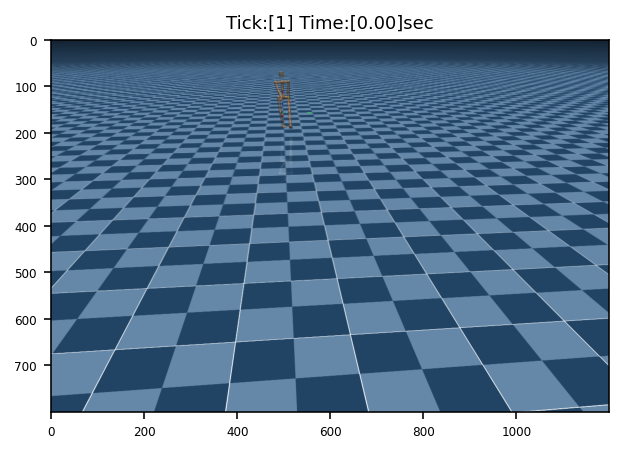

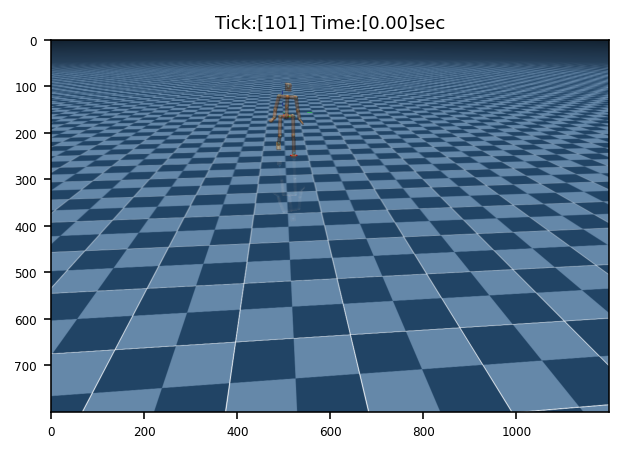

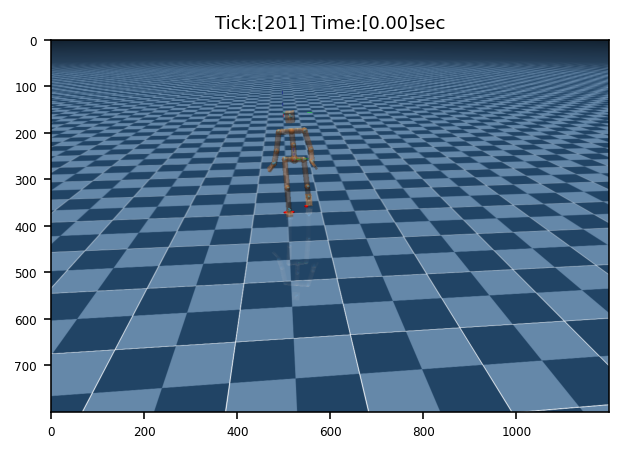

Done.


In [11]:
env.init_viewer(viewer_title='Snapbot',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=174.08,distance=0.7,elevation=-23,lookat=[15.1,0.05,2.16],
                  VIS_TRANSPARENT=True,VIS_CONTACTPOINT=True,
                  contactwidth=0.2,contactheight=0.1,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
t = 0 # timestep
num_joints = len(DOF_OFFSETS) - 1

while t<root_motion.shape[0]:
    tic = time.time()
    root_pos = root_motion[t, :3]
    root_rot = root_motion[t, 3:6]
    dof_pos = torch.tensor(dof_poses[t, :])
    
    # Angular velocity to Euler angles
    for j in range(num_joints):
        dof_offset = DOF_OFFSETS[j]
        dof_size = DOF_OFFSETS[j + 1] - DOF_OFFSETS[j]
        if (dof_size == 3):
            quat = exp_map_to_quat(dof_pos[[dof_offset,dof_offset+2,dof_offset+1]].unsqueeze(dim=0))
            r,p,y = get_euler_xyz(quat)
            dof_pos[dof_offset] = r
            dof_pos[dof_offset+2] = p
            dof_pos[dof_offset+1] = y
        

    # Render origin and base
    jntadr = env.model.body('base').jntadr[0]
    qposadr = env.model.jnt_qposadr[jntadr]
    env.data.qpos[qposadr:qposadr+3] = root_pos
    env.data.qpos[qposadr+3:qposadr+7] = r2quat(rpy2r(rpy_rad=root_rot))

    env.forward(q=np.array(dof_pos),joint_idxs=env.rev_joint_idxs+6)

    p_torso,R_torso = env.get_pR_body(body_name='torso')
    env.plot_T(p=np.zeros(3),R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0,axis_width=0.0025)
    env.plot_T(p=p_torso,R=R_torso,PLOT_AXIS=True,axis_len=0.2,axis_width=0.0025)
    # Render contact information
    PLOT_CONTACT = False
    if PLOT_CONTACT:
        p_contacts,f_contacts,geom1s,geom2s = env.get_contact_info()
        for (p_contact,f_contact,geom1,geom2) in zip(p_contacts,f_contacts,geom1s,geom2s):
            f_norm = np.linalg.norm(f_contact)
            f_uv = f_contact / (f_norm+1e-8)
            f_len = 0.2 # f_norm*0.05
            label = '[%s]-[%s]'%(geom1,geom2)
            env.plot_arrow(p=p_contact,uv=f_uv,r_stem=0.01,len_arrow=f_len,rgba=[1,0,0,0.4],label='')
            env.plot_arrow(p=p_contact,uv=-f_uv,r_stem=0.01,len_arrow=f_len,rgba=[1,0,0,0.4],label='')
            env.plot_sphere(p=p_contact,r=0.0001,label=label)
    # Render sensor locations
    for sensor_name in env.sensor_names:
        p_sensor,R_sensor = env.get_pR_sensor(sensor_name)
        env.plot_T(p=p_sensor,R=R_sensor,PLOT_AXIS=True,axis_len=0.05,axis_width=0.0025)
    # Render contacted sensor
    contact_idxs = np.where(env.get_sensor_values(sensor_names=env.sensor_names) > 1.0)[0]
    for idx in contact_idxs:
        sensor_name = env.sensor_names[idx]
        p_sensor = env.get_p_sensor(sensor_name)
        env.plot_sphere(p=p_sensor,r=0.02,rgba=[1,0,0,0.5])
    # Do render
    env.render()
    # Plot
    if env.loop_every(HZ=2) or (env.tick == 1):
        scene_img = env.grab_image(resize_rate=0.5)
        plt.figure(figsize=(5,4)); plt.imshow(scene_img)
        plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
        plt.show()
    toc = time.time() - tic
    if toc < 0.033:
        time.sleep(0.033 - toc)
    else:
        print ("Warning: rendering is slower than 60Hz.")
    t += 1
            
# Close viewer
env.close_viewer()
print ("Done.")

In [12]:
env.close_viewer()